# IJCNN

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_classification import GPC

from sklearn.cluster import KMeans

from vi_svi_class_experiments import run_methods
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Данные

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Classification/ijcnn1(49990,22).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
x_test, y_test = load_svmlight_file('../../../../Programming/DataSets/Classification/ijcnn1_test(91701,22).txt')
x_test, y_test = shuffle(x_test, y_test, random_state=230)
x_test = x_test[:8000, :]
y_test = y_test[:8000]
data_name = 'ijcnn'

x_tr = x_tr.toarray()
x_test = x_test.toarray()
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr).T
x_test = scaler.transform(x_test).T

x_tr = (x_tr + 1) / 2
x_test = (x_test + 1) / 2
y_tr = y_tr[:, None]
y_test = y_test[:, None]
y_tr[y_tr == 0] = -1
y_test[y_test == 0] = -1
dim, num = x_tr.shape

print('of objects:', num)
print('of features:', dim)
print(data_name)

of objects: 35000
of features: 22
ijcnn


## K-Means cluster centers

In [3]:
ind_num = 100
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [31]:
cov_params = np.array([10., 20., .1])

## svi-L-BFGS-B-c method

In [32]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
svi_gp = GPC(model_covariance_obj, method='svi')

In [33]:
opts = {'mode': 'full', 'maxiter': 100, 'mydisp': True}
svi_res = svi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Hyper-parameters at iteration 0 : [ 10.   20.    0.1   0.    0. ]
Hyper-parameters at iteration 1 : [  1.00012780e+01   1.99962267e+01   5.21819681e-01  -1.94654840e-02
  -1.16229340e-01]
Hyper-parameters at iteration 2 : [  9.97990063  19.99353314   0.26460446  -0.16966981  -0.80989622]
Hyper-parameters at iteration 3 : [  9.97719232  19.98869996   0.17598408  -0.24182403  -1.10739343]
Hyper-parameters at iteration 4 : [  9.97600085  19.98146191   0.18842116  -0.33011074  -1.46743958]
Hyper-parameters at iteration 5 : [  9.97489348  19.96836291   0.25521643  -0.50467553  -2.017685  ]
Hyper-parameters at iteration 6 : [  9.97317512  19.96001146   0.30293724  -0.62669944  -2.37578314]
Hyper-parameters at iteration 7 : [  9.96326233  19.95646978   0.35718086  -0.75153444  -2.65966918]
Hyper-parameters at iteration 8 : [  9.94289454  19.95852747   0.41738041  -0.88098186  -2.87899368]
Hyper-parameters at iteration 9 : [  9.91021956  19.96643017   0.4871981   -1.02428466  -3.0484954 ]
Hype

In [34]:
metric = lambda w: svi_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 't', freq=10)

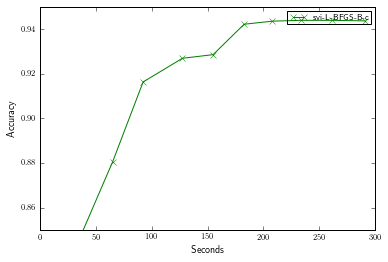

In [41]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.85, .95])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## vi-means-c method

In [37]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')

In [47]:
opts = {'maxiter':9, 'mydisp': True}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=10)

Hyper-parameters at iteration 0 : [  2.53135414e+01   1.08575355e+01   1.00000000e-02]
Hyper-parameters at iteration 1 : [  2.52257422e+01   1.13304879e+01   1.00000000e-02]
Hyper-parameters at iteration 2 : [  2.52377799e+01   1.12676395e+01   1.00000000e-02]
Hyper-parameters at iteration 3 : [  2.52402979e+01   1.12547253e+01   1.00000000e-02]
Hyper-parameters at iteration 4 : [  2.52534114e+01   1.11990902e+01   1.00000000e-02]
Hyper-parameters at iteration 5 : [  2.52577568e+01   1.11808873e+01   1.00000000e-02]
Hyper-parameters at iteration 6 : [  2.52577568e+01   1.11808873e+01   1.00000000e-02]
	Hyper-parameters at outter iteration 0 : [  2.52577568e+01   1.11808873e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  2.52577568e+01   1.11808873e+01   1.00000000e-02]
	Hyper-parameters at outter iteration 1 : [  2.52577568e+01   1.11808873e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  2.52577568e+01   1.11808873e+01   1.00000000e-02]
Hyper-parameters at iterati

In [48]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 't', freq=1)

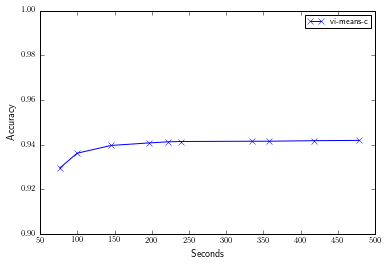

In [49]:
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## svi-AdaDelta-c
Подберем шаг для метода

In [42]:
results = []
steps = [1., 0.5, 0.3, 0.1, 0.01]
for step in steps:
    print(step)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 20, 'verbose': False, 'batch_size': 50, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)

1.0
0.5
0.3
0.1
0.01


/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:605: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


0
1
2
3
4


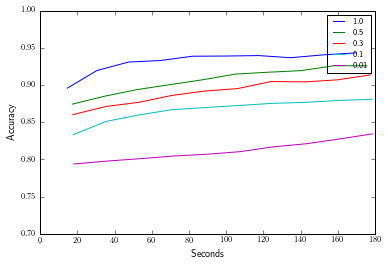

In [43]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=2)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0.7, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [44]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)
opts = {'mode': 'adadelta', 'maxiter': 30, 'verbose': True, 'batch_size': 50, 
        'step_rate': 1., 'print_freq':1}
batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Iteration  700 :
	Gradient norm 2.61457489893
Iteration  1400 :
	Gradient norm 2.7754944035
Iteration  2100 :
	Gradient norm 3.92657587612
Iteration  2800 :
	Gradient norm 7.17826089026
Iteration  3500 :
	Gradient norm 2.80018120431
Iteration  4200 :
	Gradient norm 2.19558085439
Iteration  4900 :
	Gradient norm 2.58653107758
Iteration  5600 :
	Gradient norm 21.5921015767
Iteration  6300 :
	Gradient norm 0.871636801142
Iteration  7000 :
	Gradient norm 3.4035997061
Iteration  7700 :
	Gradient norm 5.39950985326
Iteration  8400 :
	Gradient norm 2.85952361004
Iteration  9100 :
	Gradient norm 1.45037107433
Iteration  9800 :
	Gradient norm 3.29766081089
Iteration  10500 :
	Gradient norm 9.04724234578
Iteration  11200 :
	Gradient norm 2.23040293629
Iteration  11900 :
	Gradient norm 3.27470663435
Iteration  12600 :
	Gradient norm 1.25613574693
Iteration  13300 :
	Gradient norm 3.22821254598
Iteration  14000 :
	Gradient norm 3.63444366785
Iteration  14700 :
	Gradient norm 1.04895983911
Iteratio

/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:605: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


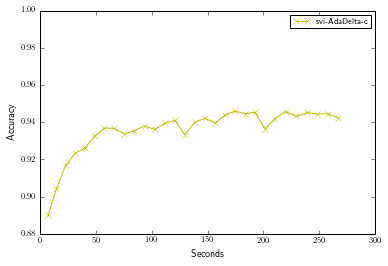

In [45]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
svi_ad_x_lst, svi_ad_y_lst = batch_res.plot_performance(metric, 't', freq=1)
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.ylim([0.88, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## Выводы

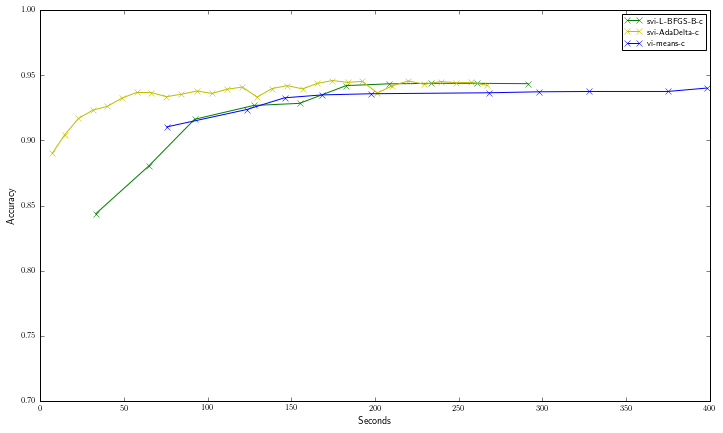

In [46]:
plt.figure(figsize=(12, 7))
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
plt.ylim([0.7, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [53]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_x.npy', svi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_y.npy', svi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_x.npy', svi_ad_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_y.npy', svi_ad_y_lst)